## Week 4. The Battle of the Neighborhoods.

### Part 1. Background.

Central America (**CAm**) is the natural land bridge between North and South America. After a century of dictatorships, civil wars and political unrest, things are looking good for this part of the world (see note), so much so that in Latin America, **CAm** has shown a bigger *average* economic growth than their neighbors in the South and the one up North ([1](https://www.mckinsey.com/featured-insights/americas/unlocking-the-economic-potential-of-central-america-and-the-caribbean)) in the last decade. Although industry is still a big part of their respective economies (especially Guatemala and Panama), an important amount of the **CAm** economies depends on internal markets, either regional or country-specific. This includes restaurants, malls, and tourism, so important questions arise, are they the same avenues or do some countries share ones that others don't?. Even if they share the same avenues, do customers differ in their reviews depending on the country?

This information will be helpful to a preliminary market research, because it will let us know where the demand for a certain service is and where is it well evaluated (allowing us to investigate further what causes the better scores).


Note: Now signs of authoritarianism are blatant in most CAm (Guatemala, Honduras, El Salvador, Nicaragua), that might impact their economies in the near future.   

### Part 2. Problem.

* ¿Do Central American countries offer the same type of avenues or do some countries have some distinctive ones?

* If they have the same ¿do the reviews differ by country?

### Part 3. Data Description.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import DBSCAN

plt.style.use('seaborn')

C:\Users\marina\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


I will be using the Foursquare data on the Central American capitals. This includes:

* Belmopán (**Belize**), 
* Guatemala City (**Guatemala**), 
* San Salvador (**El Salvador**), 
* Tegicigalpa (**Honduras**), 
* Managua (**Nicaragua**), 
* San José (**Costa Rica**), 
* and Panamá City (**Panamá**). 

In [2]:
geo_capitals = pd.read_csv("./capitals-geolocation/concap.csv")

# Select only those that are marked as being in Central America
geo_capitals[geo_capitals['ContinentName'] == 'Central America'].head() # Only first 5

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
29,Belize,Belmopan,17.250000,-88.766667,BZ,Central America
45,Canada,Ottawa,45.416667,-75.700000,CA,Central America
59,Costa Rica,San Jose,9.933333,-84.083333,CR,Central America
72,El Salvador,San Salvador,13.700000,-89.200000,SV,Central America
90,Greenland,Nuuk,64.183333,-51.750000,GL,Central America


Thanks to the Kaggle user [*Grecnik*](https://www.kaggle.com/nikitagrec) for the geolocation data on the capitals of the world.

As we can see, although the countries stated before are there, we also have other countries like Canada or Greenland, which we know are not in Central America, so we'll have to clean that up. Knowing this is not a bad idea to make sure the geolacation data is correct, so we can make some Folium maps with the data.

In [3]:
central_geo = geo_capitals[geo_capitals['ContinentName'] == 'Central America'].copy(deep=True)
central_geo

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
29,Belize,Belmopan,17.250000,-88.766667,BZ,Central America
45,Canada,Ottawa,45.416667,-75.700000,CA,Central America
59,Costa Rica,San Jose,9.933333,-84.083333,CR,Central America
72,El Salvador,San Salvador,13.700000,-89.200000,SV,Central America
90,Greenland,Nuuk,64.183333,-51.750000,GL,Central America
93,Guatemala,Guatemala City,14.616667,-90.516667,GT,Central America
100,Honduras,Tegucigalpa,14.100000,-87.216667,HN,Central America
142,Mexico,Mexico City,19.433333,-99.133333,MX,Central America
156,Nicaragua,Managua,12.133333,-86.250000,NI,Central America
166,Panama,Panama City,8.966667,-79.533333,PA,Central America


In [4]:
central_geo.drop(index=[45, 90, 142, 183, 184, 227], inplace=True)
central_geo

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
29,Belize,Belmopan,17.250000,-88.766667,BZ,Central America
59,Costa Rica,San Jose,9.933333,-84.083333,CR,Central America
72,El Salvador,San Salvador,13.700000,-89.200000,SV,Central America
93,Guatemala,Guatemala City,14.616667,-90.516667,GT,Central America
100,Honduras,Tegucigalpa,14.100000,-87.216667,HN,Central America
156,Nicaragua,Managua,12.133333,-86.250000,NI,Central America
166,Panama,Panama City,8.966667,-79.533333,PA,Central America


With this information we'll use the ***Foursquare API*** to get all the venues in the different cities, and we'll be getting **the rating of each of them**. Since a free account only allows for 50 premium calls per day, in case that is not enough the data acquired will be stored in a csv file, with the help of the *Pandas* library.

In [5]:
# The final Data Frame should look something like this, but with average scores on each venue
ca_venues = pd.read_csv("ca_venues.csv")
ca_venues.head()

,Unnamed: 0,City,City Latitude,City Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
0,0,Belmopan,17.25,-88.766667,Moon Clusters,51411144e4b043b9424634d6,17.250410,-88.764992,Café
1,1,Belmopan,17.25,-88.766667,Bull Frog Inn,5048b9fce4b0e33cddc0698f,17.251791,-88.764494,Hotel
2,2,Belmopan,17.25,-88.766667,BBQ Spot,5691551a498e8f20fed364ee,17.246916,-88.765686,BBQ Joint
3,3,Belmopan,17.25,-88.766667,Betty’s Fast Food,5c6709f212c8f0002c90a5c0,17.251902,-88.763106,Fast Food Restaurant
4,4,Belmopan,17.25,-88.766667,"Belmopan City, Belize",53c3e05a498e5ef87c0027c8,17.246987,-88.770134,Intersection


In [6]:
dummy = ca_venues[['City', 'Venue Category', 'Venue']]

### Part 4. Analysis

In [7]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [9]:
# Here we can see the different venue categories found in the capitals
pd.pivot_table(ca_venues, 
               columns='Venue Category', 
               index='City', 
               aggfunc='count')

City Latitude                                         \
Venue Category   Art Gallery Asian Restaurant BBQ Joint Bakery  Bar   
City                                                                  
Belmopan                 NaN              NaN       1.0    NaN  NaN   
Guatemala City           2.0              1.0       NaN    NaN  1.0   
Managua                  NaN              NaN       NaN    NaN  NaN   
Panama City              NaN              NaN       NaN    NaN  NaN   
San Jose                 NaN              NaN       NaN    1.0  1.0   
San Salvador             NaN              NaN       NaN    NaN  NaN   
Tegucigalpa              NaN              NaN       NaN    NaN  NaN   

                                                                           \
Venue Category Big Box Store Boutique Breakfast Spot Brewery Burger Joint   
City                                                                        
Belmopan                 NaN      NaN            NaN     NaN          NaN   
Guatemala City           NaN      NaN            1.0     1.0          2.0   
Managua                  1.0      NaN            2.0     NaN          NaN   
Panama City              NaN      NaN            NaN     NaN          NaN   
San Jose                 NaN      1.0            NaN     NaN          1.0   
San Salvador             NaN      NaN            NaN     NaN          NaN   
Tegucigalpa              NaN      NaN            NaN     NaN          NaN   

                ...   Venue id                                                \
Venue Category  ... Public Art Rental Car Location Restaurant Sandwich Place   
City            ...                                                            
Belmopan        ...        NaN                 NaN        NaN            NaN   
Guatemala City  ...        1.0                 1.0        2.0            1.0   
Managua         ...        NaN                 NaN        NaN            NaN   
Panama City     ...        NaN                 NaN        NaN            NaN   
San Jose        ...        NaN                 NaN        3.0            4.0   
San Salvador    ...        NaN                 NaN        NaN            NaN   
Tegucigalpa     ...        NaN                 NaN        1.0            NaN   

                                                                         \
Venue Category Scenic Lookout Snack Place Sports Bar Steakhouse Theater   
City                                                                      
Belmopan                  NaN         NaN        NaN        NaN     NaN   
Guatemala City            NaN         NaN        NaN        1.0     NaN   
Managua                   NaN         NaN        1.0        NaN     NaN   
Panama City               1.0         NaN        NaN        NaN     1.0   
San Jose                  NaN         2.0        NaN        NaN     1.0   
San Salvador              NaN         NaN        NaN        NaN     NaN   
Tegucigalpa               NaN         NaN        NaN        NaN     NaN   

                                              
Venue Category Vegetarian / Vegan Restaurant  
City                                          
Belmopan                                 NaN  
Guatemala City                           1.0  
Managua                                  NaN  
Panama City                              NaN  
San Jose                                 NaN  
San Salvador                             NaN  
Tegucigalpa                              NaN  

[7 rows x 406 columns]

In [10]:
# And here we can see which city has the most varied venues
venue_counts = pd.pivot_table(ca_venues, 
                               values='Venue Category', 
                               index='City', 
                               aggfunc='count').sort_values(by='Venue Category',
                                                           ascending=False)

venue_counts

,Venue Category
City,
San Jose,40
Guatemala City,26
San Salvador,13
Panama City,10
Managua,9
Belmopan,5
Tegucigalpa,3


An alternative:

In [11]:
ca_venues.groupby(by=['City'])['Venue Category'].count().reset_index()

,City,Venue Category
0,Belmopan,5
1,Guatemala City,26
2,Managua,9
3,Panama City,10
4,San Jose,40
5,San Salvador,13
6,Tegucigalpa,3


Once we have the entire dataset we'll use a clustering algorithm to know which countries share a commonality with each other. After that will use classification algorithm to see if the average avenue score per country is indicative of something.

Text(0, 0.5, 'Number of Categories')

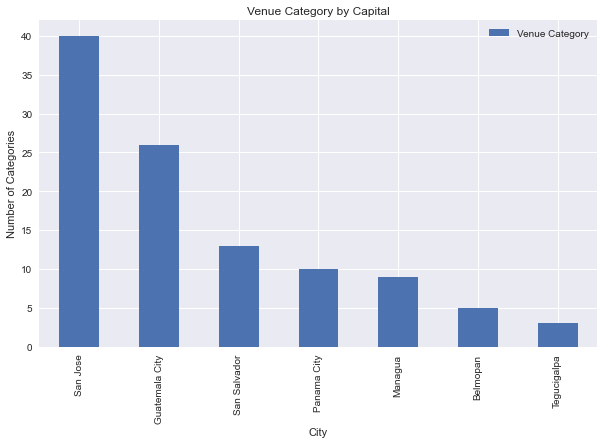

In [12]:
ax = venue_counts.plot(kind='bar', figsize=(10, 6))
ax.set_title(label='Venue Category by Capital', fontdict={'fontsize':12})
ax.set_ylabel('Number of Categories')

In [13]:
type_venue_counts = pd.pivot_table(ca_venues, 
                               values='City', 
                               index='Venue Category', 
                               aggfunc='count').sort_values(by='City',
                                                           ascending=False)

type_venue_counts.head()

,City
Venue Category,
Fast Food Restaurant,9
Restaurant,6
Latin American Restaurant,5
Sandwich Place,5
Café,5


Text(0, 0.5, 'Frequency')

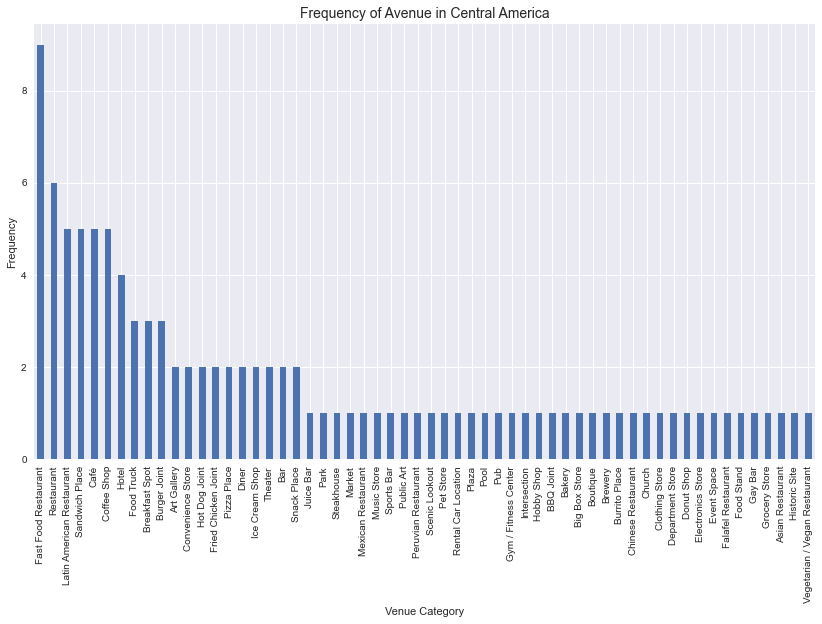

In [14]:
ax = type_venue_counts.plot(kind='bar', figsize=(14, 8), legend=False)
ax.set_title(label='Frequency of Avenue in Central America', fontdict={'fontsize':14})
ax.set_ylabel('Frequency')

In [15]:
# one hot encoding
ca_onehot = pd.get_dummies(ca_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ca_onehot['City'] = ca_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [ca_onehot.columns[-1]] + list(ca_onehot.columns[:-1])
ca_onehot = ca_onehot[fixed_columns]

ca_onehot.head()

,City,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Big Box Store,Boutique,Breakfast Spot,Brewery,...,Public Art,Rental Car Location,Restaurant,Sandwich Place,Scenic Lookout,Snack Place,Sports Bar,Steakhouse,Theater,Vegetarian / Vegan Restaurant
0,Belmopan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Belmopan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Belmopan,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Belmopan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Belmopan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
ca_onehot.shape

(106, 59)

In [17]:
ca_grouped = ca_onehot.groupby('City').mean().reset_index()
ca_grouped

,City,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Big Box Store,Boutique,Breakfast Spot,Brewery,...,Public Art,Rental Car Location,Restaurant,Sandwich Place,Scenic Lookout,Snack Place,Sports Bar,Steakhouse,Theater,Vegetarian / Vegan Restaurant
0,Belmopan,0.000000,0.000000,0.2,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000,0.000000
1,Guatemala City,0.076923,0.038462,0.0,0.000,0.038462,0.000000,0.000,0.038462,0.038462,...,0.038462,0.038462,0.076923,0.038462,0.0,0.00,0.000000,0.038462,0.000,0.038462
2,Managua,0.000000,0.000000,0.0,0.000,0.000000,0.111111,0.000,0.222222,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.111111,0.000000,0.000,0.000000
3,Panama City,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.1,0.00,0.000000,0.000000,0.100,0.000000
4,San Jose,0.000000,0.000000,0.0,0.025,0.025000,0.000000,0.025,0.000000,0.000000,...,0.000000,0.000000,0.075000,0.100000,0.0,0.05,0.000000,0.000000,0.025,0.000000
5,San Salvador,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000,0.000000
6,Tegucigalpa,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.333333,0.000000,0.0,0.00,0.000000,0.000000,0.000,0.000000


In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ca_venues_sorted = pd.DataFrame(columns=columns)
ca_venues_sorted['City'] = ca_grouped['City']

for ind in np.arange(ca_grouped.shape[0]):
    ca_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ca_grouped.iloc[ind, :], num_top_venues)

ca_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Belmopan,BBQ Joint,Fast Food Restaurant,Hotel,Intersection,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Food Truck,Food Stand,Falafel Restaurant
1,Guatemala City,Art Gallery,Burger Joint,Restaurant,Café,Hot Dog Joint,Hotel,Asian Restaurant,Bar,Breakfast Spot,Brewery
2,Managua,Breakfast Spot,Chinese Restaurant,Convenience Store,Sports Bar,Pet Store,Hobby Shop,Big Box Store,Mexican Restaurant,Donut Shop,Department Store
3,Panama City,Fast Food Restaurant,Hotel,Park,Pool,Theater,Scenic Lookout,Latin American Restaurant,Diner,Coffee Shop,Convenience Store
4,San Jose,Sandwich Place,Coffee Shop,Fast Food Restaurant,Latin American Restaurant,Restaurant,Snack Place,Ice Cream Shop,Grocery Store,Church,Market


In [19]:
from sklearn.neighbors import NearestNeighbors

ca_grouped_clustering = ca_grouped.drop('City', 1)

neigh = NearestNeighbors(n_neighbors=2).fit(ca_grouped_clustering)

distances, indices = neigh.kneighbors(ca_grouped_clustering)

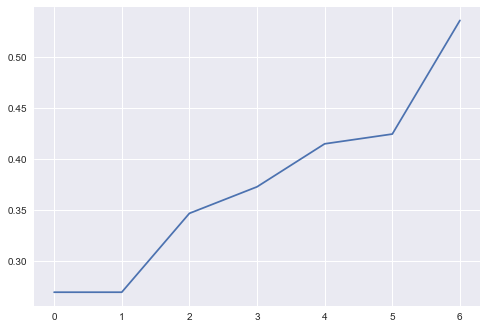

In [20]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [21]:
ca_grouped_clustering = ca_grouped.drop('City', 1)

# run k-means clustering
ca_dbscan = DBSCAN(eps=0.45).fit(ca_grouped_clustering)

# check cluster labels generated for each row in the dataframe
ca_dbscan.labels_[0:10] 

array([ 0,  0,  0,  0,  0,  0, -1], dtype=int64)

In [22]:
# add clustering labels
ca_venues_sorted.insert(0, 'Cluster Labels', ca_dbscan.labels_)

ca_merged = central_geo

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
ca_merged = ca_merged.join(ca_venues_sorted.set_index('City'), on='CapitalName')

ca_merged.head() # check the last columns!

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Belize,Belmopan,17.250000,-88.766667,BZ,Central America,0,BBQ Joint,Fast Food Restaurant,Hotel,Intersection,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Food Truck,Food Stand,Falafel Restaurant
59,Costa Rica,San Jose,9.933333,-84.083333,CR,Central America,0,Sandwich Place,Coffee Shop,Fast Food Restaurant,Latin American Restaurant,Restaurant,Snack Place,Ice Cream Shop,Grocery Store,Church,Market
72,El Salvador,San Salvador,13.700000,-89.200000,SV,Central America,0,Food Truck,Clothing Store,Coffee Shop,Fried Chicken Joint,Café,Pizza Place,Plaza,Latin American Restaurant,Music Store,Donut Shop
93,Guatemala,Guatemala City,14.616667,-90.516667,GT,Central America,0,Art Gallery,Burger Joint,Restaurant,Café,Hot Dog Joint,Hotel,Asian Restaurant,Bar,Breakfast Spot,Brewery
100,Honduras,Tegucigalpa,14.100000,-87.216667,HN,Central America,-1,Fast Food Restaurant,Restaurant,Electronics Store,Vegetarian / Vegan Restaurant,Church,Food Truck,Food Stand,Falafel Restaurant,Event Space,Donut Shop


In [23]:
ca_dbscan.labels_

array([ 0,  0,  0,  0,  0,  0, -1], dtype=int64)

In [24]:
# create map
map_clusters = folium.Map(location=[12.769013, -85.602364], zoom_start=6)

# set color scheme for the clusters
x = np.arange(2)
ys = [i + x + (i*x)**2 for i in range(2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ca_merged['CapitalLatitude'], ca_merged['CapitalLongitude'], ca_merged['CapitalName'], ca_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### First Conclusions

With only the basic avenue's information we can see that Honduras is the only one in the region that appears to be an outsider.

### Part 5. Data with likes

We have thus far analised the venues only with their category, but Foursquare allows us to dig deeper, so that's what we are going to do. Since premium calls are restricted to 50 per day we did the requests days before and stored the results in csv files. After that we cleaned the data, until we were left with the premium_calls.csv file.

In [25]:
venue_info = pd.read_csv("premium_calls.csv")
venue_info.head()

,Unnamed: 0,response.venue.id,response.venue.name,response.venue.price.message,response.venue.likes.summary,response.venue.dislike
0,0,51411144e4b043b9424634d6,Moon Clusters,Cheap,1 Like,False
1,1,5048b9fce4b0e33cddc0698f,Bull Frog Inn,NaN,2 Likes,False
2,2,5691551a498e8f20fed364ee,BBQ Spot,Moderate,NaN,False
3,3,5c6709f212c8f0002c90a5c0,Betty’s Fast Food,Cheap,NaN,False
4,4,53c3e05a498e5ef87c0027c8,"Belmopan City, Belize",NaN,1 Like,False


First of all we need to clean this final table, removed the 'Unnamed: 0' column and change the column names.

In [26]:
venue_info.drop(labels='Unnamed: 0',axis=1, inplace=True)
venue_info.columns

Index(['response.venue.id', 'response.venue.name',
       'response.venue.price.message', 'response.venue.likes.summary',
       'response.venue.dislike'],
      dtype='object')

In [27]:
venue_info.columns = ['id', 'Name', 'Price', 'Likes', 'Disliked?']
venue_info.head()

,id,Name,Price,Likes,Disliked?
0,51411144e4b043b9424634d6,Moon Clusters,Cheap,1 Like,False
1,5048b9fce4b0e33cddc0698f,Bull Frog Inn,NaN,2 Likes,False
2,5691551a498e8f20fed364ee,BBQ Spot,Moderate,NaN,False
3,5c6709f212c8f0002c90a5c0,Betty’s Fast Food,Cheap,NaN,False
4,53c3e05a498e5ef87c0027c8,"Belmopan City, Belize",NaN,1 Like,False


Now that we have done that, we need to extract the numbers in the 'Likes' column and change its type for it to be used as numbers in the analysis.

In [28]:
# Let's extract only the number of likes for each venue
venue_info['Likes'] = venue_info['Likes'].str.extract(r'([0-9]+)', expand=False)
venue_info.head()

,id,Name,Price,Likes,Disliked?
0,51411144e4b043b9424634d6,Moon Clusters,Cheap,1,False
1,5048b9fce4b0e33cddc0698f,Bull Frog Inn,NaN,2,False
2,5691551a498e8f20fed364ee,BBQ Spot,Moderate,NaN,False
3,5c6709f212c8f0002c90a5c0,Betty’s Fast Food,Cheap,NaN,False
4,53c3e05a498e5ef87c0027c8,"Belmopan City, Belize",NaN,1,False


In [29]:
ca_venues.drop(labels='Unnamed: 0', axis=1, inplace=True)
ca_venues.head()

,City,City Latitude,City Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
0,Belmopan,17.25,-88.766667,Moon Clusters,51411144e4b043b9424634d6,17.250410,-88.764992,Café
1,Belmopan,17.25,-88.766667,Bull Frog Inn,5048b9fce4b0e33cddc0698f,17.251791,-88.764494,Hotel
2,Belmopan,17.25,-88.766667,BBQ Spot,5691551a498e8f20fed364ee,17.246916,-88.765686,BBQ Joint
3,Belmopan,17.25,-88.766667,Betty’s Fast Food,5c6709f212c8f0002c90a5c0,17.251902,-88.763106,Fast Food Restaurant
4,Belmopan,17.25,-88.766667,"Belmopan City, Belize",53c3e05a498e5ef87c0027c8,17.246987,-88.770134,Intersection


Then we can join the ca_venues dataframe with the full information venues on the ids, so we can have the full scope.

In [31]:
full_venues = ca_venues.join(venue_info.set_index('id'), on='Venue id')
full_venues.head()

,City,City Latitude,City Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,Name,Price,Likes,Disliked?
0,Belmopan,17.25,-88.766667,Moon Clusters,51411144e4b043b9424634d6,17.250410,-88.764992,Café,Moon Clusters,Cheap,1,False
1,Belmopan,17.25,-88.766667,Bull Frog Inn,5048b9fce4b0e33cddc0698f,17.251791,-88.764494,Hotel,Bull Frog Inn,NaN,2,False
2,Belmopan,17.25,-88.766667,BBQ Spot,5691551a498e8f20fed364ee,17.246916,-88.765686,BBQ Joint,BBQ Spot,Moderate,NaN,False
3,Belmopan,17.25,-88.766667,Betty’s Fast Food,5c6709f212c8f0002c90a5c0,17.251902,-88.763106,Fast Food Restaurant,Betty’s Fast Food,Cheap,NaN,False
4,Belmopan,17.25,-88.766667,"Belmopan City, Belize",53c3e05a498e5ef87c0027c8,17.246987,-88.770134,Intersection,"Belmopan City, Belize",NaN,1,False


In [32]:
full_venues['Likes'] = pd.to_numeric(full_venues['Likes'])

Text(0, 0.5, 'Number of likes')

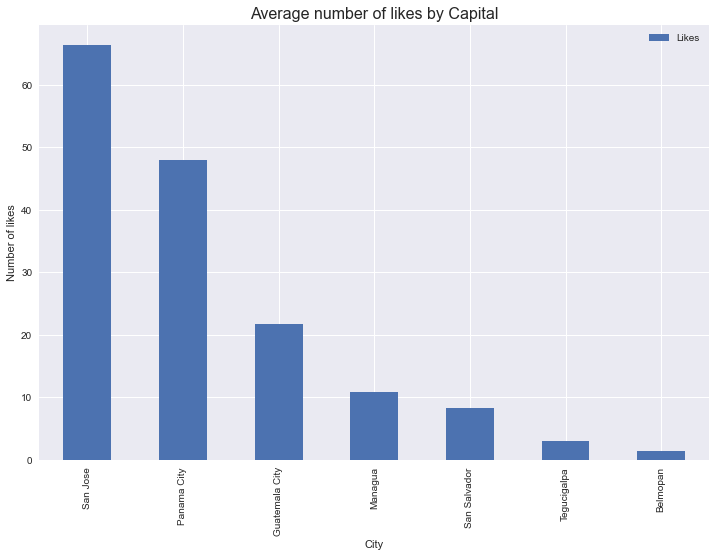

In [33]:
ax = full_venues[['City', 'Likes']].groupby('City').mean().sort_values('Likes', 
                                                                  ascending=False).plot(kind='bar', figsize=(12, 8))

ax.set_title(label='Average number of likes by Capital', fontdict={'fontsize':16})
ax.set_ylabel('Number of likes')

In order for the machine learning algorithms to use the data we need to standardized it. First we begin with the numerical data.

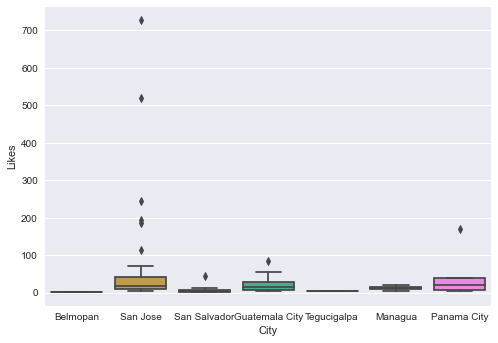

In [34]:
sns.boxplot(x=full_venues['City'], y=full_venues['Likes'])

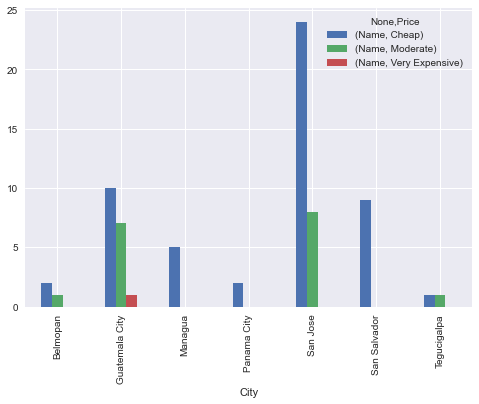

In [35]:
full_venues[['City', 'Price', 'Name']].pivot_table(index='City', columns='Price', aggfunc='count').plot(kind='bar')

In [36]:
# apply the robust scaling in Pandas using the .median() and .quantile() methods
def robust_scaling(df):
    # copy the dataframe
    df_robust = df.copy()
    # apply robust scaling
    df_robust = (df_robust - df_robust.median())  / (df_robust.quantile(0.75) - df_robust.quantile(0.25))
    return df_robust
    
# call the robust_scaling function
likes_robust = robust_scaling(full_venues['Likes'])

likes_robust

0     -0.586667
1     -0.533333
2           NaN
3           NaN
4     -0.586667
         ...   
101         NaN
102         NaN
103         NaN
104         NaN
105         NaN
Name: Likes, Length: 106, dtype: float64

Then we proceed with the categorical values, that need to be transform into numeric ones. This can be achieved through one hot encoding.

In [37]:
full_onehot = pd.get_dummies(full_venues[['Venue Category', 'Price', 'Disliked?']], 
                             prefix="", 
                             prefix_sep="")

# add neighborhood column back to dataframe
full_onehot['Likes'] = likes_robust
full_onehot['City'] = full_venues['City']

# move neighborhood column to the first column
fixed_columns = [full_onehot.columns[-1]] + list(full_onehot.columns[:-1])
full_onehot = full_onehot[fixed_columns]

full_onehot

,City,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Big Box Store,Boutique,Breakfast Spot,Brewery,...,Snack Place,Sports Bar,Steakhouse,Theater,Vegetarian / Vegan Restaurant,Cheap,Moderate,Very Expensive,False,Likes
0,Belmopan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-0.586667
1,Belmopan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.533333
2,Belmopan,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,NaN
3,Belmopan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,NaN
4,Belmopan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.586667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Panama City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
102,Panama City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
103,Panama City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
104,Panama City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [38]:
full_grouped = full_onehot.groupby('City').mean().reset_index()
full_grouped

,City,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Big Box Store,Boutique,Breakfast Spot,Brewery,...,Snack Place,Sports Bar,Steakhouse,Theater,Vegetarian / Vegan Restaurant,Cheap,Moderate,Very Expensive,False,Likes
0,Belmopan,0.000000,0.000000,0.2,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000,0.000000,0.400000,0.200000,0.000000,1.000000,-0.568889
1,Guatemala City,0.076923,0.038462,0.0,0.000,0.038462,0.000000,0.000,0.038462,0.038462,...,0.00,0.000000,0.038462,0.000,0.038462,0.384615,0.269231,0.038462,1.000000,0.518400
2,Managua,0.000000,0.000000,0.0,0.000,0.000000,0.111111,0.000,0.222222,0.000000,...,0.00,0.111111,0.000000,0.000,0.000000,0.555556,0.000000,0.000000,1.000000,-0.059259
3,Panama City,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.100,0.000000,0.200000,0.000000,0.000000,0.500000,1.920000
4,San Jose,0.000000,0.000000,0.0,0.025,0.025000,0.000000,0.025,0.000000,0.000000,...,0.05,0.000000,0.000000,0.025,0.000000,0.600000,0.200000,0.000000,1.000000,2.897333
5,San Salvador,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000,0.000000,0.692308,0.000000,0.000000,0.923077,-0.203636
6,Tegucigalpa,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000,0.000000,0.333333,0.333333,0.000000,1.000000,-0.480000


Then to make sure what Epsilon value to use in the DBSCAN algorithm we ran Nearest Neighbors with this new data.

In [39]:
full_grouped_clustering = full_grouped.drop('City', 1)

neigh = NearestNeighbors(n_neighbors=2).fit(full_grouped_clustering)

distances, indices = neigh.kneighbors(full_grouped_clustering)

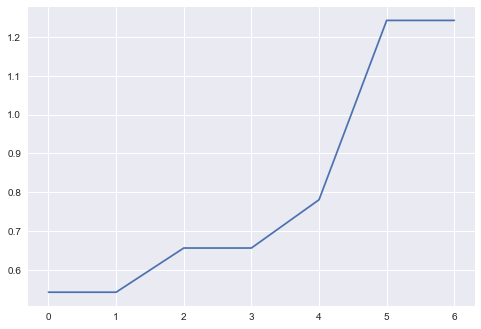

In [40]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Even with the new data, we see that the elbow is not as well defined. Even so it seems that a epsilon value of 0.9 makes the separation better.

In [41]:
full_grouped_clustering = full_grouped.drop('City', 1)

# run k-means clustering
full_dbscan = DBSCAN(eps=0.9).fit(full_grouped_clustering)

# check cluster labels generated for each row in the dataframe
full_dbscan.labels_[0:10] 

array([ 0,  0,  0, -1, -1,  0,  0], dtype=int64)

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
full_venues_sorted = pd.DataFrame(columns=columns)
full_venues_sorted['City'] = full_grouped['City']

for ind in np.arange(full_grouped.shape[0]):
    full_venues_sorted.iloc[ind, 1:] = return_most_common_venues(full_grouped.iloc[ind, :], num_top_venues)

full_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Belmopan,False,Cheap,Moderate,BBQ Joint,Hotel,Intersection,Fast Food Restaurant,Café,Hobby Shop,Event Space
1,Guatemala City,False,Likes,Cheap,Moderate,Restaurant,Burger Joint,Café,Hot Dog Joint,Art Gallery,Fried Chicken Joint
2,Managua,False,Cheap,Breakfast Spot,Sports Bar,Mexican Restaurant,Chinese Restaurant,Convenience Store,Hobby Shop,Big Box Store,Pet Store
3,Panama City,Likes,False,Fast Food Restaurant,Cheap,Hotel,Scenic Lookout,Pool,Diner,Latin American Restaurant,Park
4,San Jose,Likes,False,Cheap,Moderate,Sandwich Place,Coffee Shop,Latin American Restaurant,Restaurant,Fast Food Restaurant,Snack Place


In [47]:
# add clustering labels
full_venues_sorted.insert(0, 'Cluster Labels', full_dbscan.labels_)

full_merged = central_geo

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
full_merged = full_merged.join(full_venues_sorted.set_index('City'), on='CapitalName')

full_merged # check the last columns!

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Belize,Belmopan,17.250000,-88.766667,BZ,Central America,0,False,Cheap,Moderate,BBQ Joint,Hotel,Intersection,Fast Food Restaurant,Café,Hobby Shop,Event Space
59,Costa Rica,San Jose,9.933333,-84.083333,CR,Central America,-1,Likes,False,Cheap,Moderate,Sandwich Place,Coffee Shop,Latin American Restaurant,Restaurant,Fast Food Restaurant,Snack Place
72,El Salvador,San Salvador,13.700000,-89.200000,SV,Central America,0,False,Cheap,Food Truck,Plaza,Café,Fast Food Restaurant,Latin American Restaurant,Donut Shop,Music Store,Coffee Shop
93,Guatemala,Guatemala City,14.616667,-90.516667,GT,Central America,0,False,Likes,Cheap,Moderate,Restaurant,Burger Joint,Café,Hot Dog Joint,Art Gallery,Fried Chicken Joint
100,Honduras,Tegucigalpa,14.100000,-87.216667,HN,Central America,0,False,Electronics Store,Moderate,Cheap,Fast Food Restaurant,Restaurant,Hobby Shop,Convenience Store,Department Store,Diner
156,Nicaragua,Managua,12.133333,-86.250000,NI,Central America,0,False,Cheap,Breakfast Spot,Sports Bar,Mexican Restaurant,Chinese Restaurant,Convenience Store,Hobby Shop,Big Box Store,Pet Store
166,Panama,Panama City,8.966667,-79.533333,PA,Central America,-1,Likes,False,Fast Food Restaurant,Cheap,Hotel,Scenic Lookout,Pool,Diner,Latin American Restaurant,Park


Once again we create the map.

In [48]:
# create map
map_clusters = folium.Map(location=[12.769013, -85.602364], zoom_start=6)

# set color scheme for the clusters
x = np.arange(2)
ys = [i + x + (i*x)**2 for i in range(2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(full_merged['CapitalLatitude'], full_merged['CapitalLongitude'], full_merged['CapitalName'], full_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Part 6. Results and Discussion

We can see two different results, apparently drived by their respective data. In the first one, where we only compared venue types between the different capitals we saw Honduras as the odd one out, which was probably a result of its low variaty in venue types. In the second one, the data told us that both Costa Rica and Panamá City had a greater average of liked than the rest of Central American capitals. This might have resulted in the new map, where these two countries seem different from the other one.

The results are preliminary at best, as we know that Foursquare doesn't have a robust information on this countries. A better analysis would come out of a bigger and fuller data set. Having said that, it isn't surprising that Panamá and Costa Rica have better reviews, as they have the second and third biggest economies in the region and also don't suffer the violence that a richer country as Guatemala does.

### Part 7. Conclusions

The goal of this analysis was to check if the capitals of all Central America countries share commonalities regarding their venues. It seems that they are not so far off, although with some minor differences. Honduras is the least known one, and Costa Rica is the highest liked, Panama being a close second. Other than that all of these seem to share some commonality. A more robust data is sure to make a clearer analysis, but a certain homogeneity seems to be the rule in Central America.

Stake holders would have a final answer, but Costa Rica looks like a more competitive ground, Honduras the least and San José has the cheapest places, Guatemala having the most expensive ones.